In [ ]:
!pip install astroML
from astroML.datasets import sdss_galaxy_images
data = sdss_galaxy_images.fetch_sdss_galaxy_images()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 5.5 MB/s 




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import cv2

In [ ]:
X, y = data[0], data[1]

In [ ]:
plt.imshow(data[0][1])
plt.show()

In [ ]:
#data aug

flip = (data[0]*0, data[1])
for i in range(1000):
  flip[0][i] = np.fliplr(data[0][i])
plt.imshow(flip[0][0])
plt.show()

rotate90 = (data[0]*0, data[1])
for i in range(1000):
  rotate90[0][i] = cv2.rotate(data[0][i], cv2.ROTATE_90_CLOCKWISE)
plt.imshow(rotate90[0][0])
plt.show()

rotate180 = (data[0]*0, data[1])
for i in range(1000):
  rotate180[0][i] = cv2.rotate(data[0][i], cv2.ROTATE_180)
plt.imshow(rotate180[0][0])
plt.show()

rotate270 = (data[0]*0, data[1])
for i in range(1000):
  rotate270[0][i] = cv2.rotate(data[0][i], cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(rotate270[0][0])
plt.show()

blur = (data[0]*0, data[1])
for i in range(1000):
  blur[0][i] = cv2.blur(data[0][i], (3,3))
plt.imshow(blur[0][1])
plt.show()

compose1 = (data[0]*0, data[1])
for i in range(1000):
  compose1[0][i] = cv2.blur(rotate90[0][i], (3,3)) 
plt.imshow(compose1[0][1])
plt.show()

compose2 = (data[0]*0, data[1])
for i in range(1000):
  compose2[0][i] = cv2.blur(flip[0][i], (3,3))
plt.imshow(compose2[0][1])
plt.show() 

compose3 = (data[0]*0, data[1])
for i in range(1000):
  compose3[0][i] = cv2.rotate(flip[0][i], cv2.ROTATE_90_CLOCKWISE) 
plt.imshow(compose3[0][1])
plt.show()

compose4 = (data[0]*0, data[1])
for i in range(1000):
  compose4[0][i] = cv2.rotate(flip[0][i], cv2.ROTATE_180)
plt.imshow(compose4[0][1])
plt.show() 

compose5 = (data[0]*0, data[1])
for i in range(1000):
  compose5[0][i] = cv2.rotate(blur[0][i], cv2.ROTATE_180) 
plt.imshow(compose5[0][1])
plt.show()

In [ ]:
y_aug = np.zeros(shape=(11000,))
for i in range(1000):
  y_aug[i] = y[i]
  y_aug[1000+i] = flip[1][i]
  y_aug[2000+i] = rotate90[1][i]
  y_aug[3000+i] = rotate180[1][i]
  y_aug[4000+i] = rotate270[1][i]
  y_aug[5000+i] = blur[1][i]
  y_aug[6000+i] = compose1[1][i]
  y_aug[7000+i] = compose2[1][i]
  y_aug[8000+i] = compose3[1][i]
  y_aug[9000+i] = compose4[1][i]
  y_aug[10000+i] = compose5[1][i]

X_aug = np.zeros(shape=(11000, 69, 69, 3))
for i in range(1000):
  X_aug[i] = X[i]
  X_aug[1000+i] = flip[0][i]
  X_aug[2000+i] = rotate90[0][i]
  X_aug[3000+i] = rotate180[0][i]
  X_aug[4000+i] = rotate270[0][i]
  X_aug[5000+i] = blur[0][i]
  X_aug[6000+i] = compose1[0][i]
  X_aug[7000+i] = compose2[0][i]
  X_aug[8000+i] = compose3[0][i]
  X_aug[9000+i] = compose4[0][i]
  X_aug[10000+i] = compose5[0][i]

In [ ]:
X_aug = X_aug.reshape(X_aug.shape[0], 69*69*3)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
outer_results=list()
y_test_best = list()
X_test_best = list()
X_train_best = list()
y_train_best = list()
for train_ix, test_ix in cv_outer.split(X_aug):
  X_train, X_test = X_aug[train_ix, :], X_aug[test_ix, :]
  y_train, y_test = y_aug[train_ix], y_aug[test_ix]
  cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
  X_test_best.append(X_test)
  y_test_best.append(y_test)
  X_train_best.append(X_train)
  y_train_best.append(y_train)
  model = RandomForestClassifier(random_state=1)
  space = dict()
  space['n_estimators'] = [10, 200, 500]
  space['max_features'] = [2, 4, 6]
  search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
  result = search.fit(X_train, y_train)
  best_model = result.best_estimator_
  yhat = best_model.predict(X_test)
  acc = accuracy_score(y_test, yhat)
  outer_results.append(acc)
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
print('Mean accuracy: %.3f (std: %.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.880, est=0.860, cfg={'max_features': 6, 'n_estimators': 500}
>acc=0.860, est=0.862, cfg={'max_features': 6, 'n_estimators': 500}
>acc=0.868, est=0.861, cfg={'max_features': 6, 'n_estimators': 500}
>acc=0.874, est=0.858, cfg={'max_features': 6, 'n_estimators': 500}
>acc=0.867, est=0.856, cfg={'max_features': 6, 'n_estimators': 500}


In [ ]:
X_test = np.array(X_test_best[0])
y_test = np.array(y_test_best[0])
X_train = np.array(X_train_best[0])
y_train = np.array(y_train_best[0])

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 69, 69, 3)
X_test = X_test.reshape(X_test.shape[0], 69, 69, 3)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

callbacks = [EarlyStopping(monitor='val_loss', min_delta = 2e-3, patience=2, verbose=1),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_delta = 2e-2, min_lr=1e-7, verbose=1),
             TerminateOnNaN()]

In [ ]:
def createModel1():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(69,69,3)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

def createModel2():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (8, 8), padding='same', activation='relu', input_shape=(69,69,3)))
    model.add(layers.Conv2D(16, (8, 8), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model  

def createModel3():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (8, 8), padding='same', activation='relu', input_shape=(69,69,3)))
    model.add(layers.Conv2D(16, (8, 8), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.20))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model1 = createModel1()
model2 = createModel2()
model3 = createModel3()
batch_size = 128
epochs = 50

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history1 = model1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_test,y_test), callbacks=callbacks)

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

"plt.plot(history1.history['loss'])\nplt.plot(history1.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'validation'], loc='best')\nplt.show()\n\nplt.plot(history1.history['accuracy'])\nplt.plot(history1.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'validation'], loc='best')\nplt.show()"

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

history2 = model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_test,y_test), callbacks=callbacks)

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

"plt.plot(history2.history['loss'])\nplt.plot(history2.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'validation'], loc='best')\nplt.show()\n\nplt.plot(history2.history['accuracy'])\nplt.plot(history2.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'validation'], loc='best')\nplt.show()"

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

history3 = model3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/50
69/69 [==============================] - 336s 5s/step - loss: 0.2751 - accuracy: 0.8836 - val_loss: 0.2914 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.8936
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 [==============================] - 334s 5s/step - loss: 0.2499 - accuracy: 0.8936 - val_loss: 0.2863 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9022
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
69/69 [==============================] - 334s 5s/step - loss: 0.2294 - accuracy: 0.9022 - val_loss: 0.2929 - val_accuracy: 0.8814 - lr: 5.0000e-04
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9086
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
69/69 [==============================] - 334s 

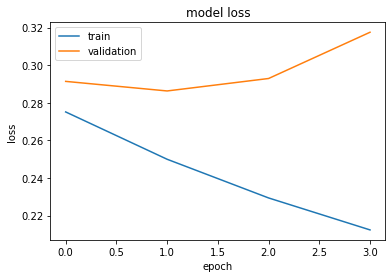

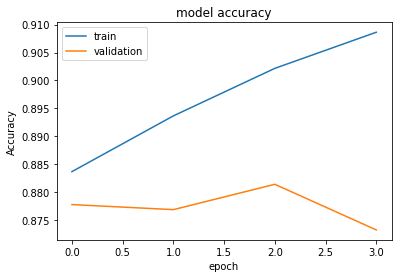

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

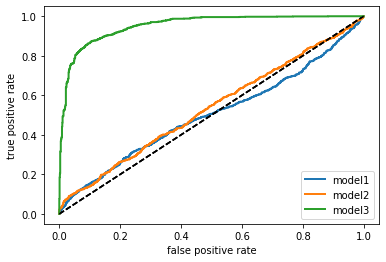

AUC model 1:  0.5016474402943194
AUC model 2:  0.5334771673837584
AUC model 3:  0.9521198894223775


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, model1.predict(X_test), drop_intermediate=False)
fpr2, tpr2, threshold2 = roc_curve(y_test, model2.predict(X_test), drop_intermediate=False)
fpr3, tpr3, threshold3 = roc_curve(y_test, model3.predict(X_test), drop_intermediate=False)

def plot_roc_curve(fpr, tpr, label, threshold=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--') 
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.legend(loc='lower right')

plot_roc_curve(fpr, tpr, "model1", threshold)
plot_roc_curve(fpr2, tpr2, "model2", threshold2)
plot_roc_curve(fpr3, tpr3, "model3", threshold3)
plt.show()

print("AUC model 1: ", roc_auc_score(y_test, model1.predict(X_test)))
print("AUC model 2: ", roc_auc_score(y_test, model2.predict(X_test)))
print("AUC model 3: ", roc_auc_score(y_test, model3.predict(X_test)))